In [46]:
import netCDF4 as nc
import pylab as py
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.cm as cm
import sys
import os
import errno


import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')
    
## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
        logging.debug('destination folder created !')
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            logging.debug('destination folder exists already!')
            raise

####################
#### soomthening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth            

dirc=np.array([0,str('aqua'),str('isca5m')])
num=1 ## represents an annual year of data
#source='/project2/tas1/pragallvaring_quarter_2018/post_process_data/'+dirc[1]+'_'+dirc[2]+str(i)+'/'

source1='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/'+dirc[1]+'_'+dirc[2]+'/'
one_year=dirc[1]+'_'+dirc[2]+str(num)+'.nc'
ncfile=source1+one_year
lat=nc.Dataset(ncfile,'r').variables['lat'][:]

stream_data=[]
uv_data=[]
Z_T_Q_data=[]
T=[]
Z=[]
U=[]

In [47]:
print 1

1


In [48]:
for i in range(0,int(num)):
 
 source='/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/data_in_pres_coord/'+dirc[1]+'_'+dirc[2]+str(i)+'/'
 Z_T_Q_data.append(load(source+"ht_temp_sphum.hkl"))   
 uv_data.append(load(source+"u_v.hkl"))   
 T.append(Z_T_Q_data[i]['temp'])
 Z.append(Z_T_Q_data[i]['ht'])
 U.append(uv_data[i]['u'])
  

In [49]:
def M(x):
    return np.mean(x,axis=0)

T=M(T) ; Z=M(Z); U=M(U)

Pres = np.array([0.5 ,10.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 600.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0])
no_of_plevels = len(Pres)
P_half=np.append(0,Pres)


Rk=287 # --> Gas constant
Cp= 1004.64 # J/kg/deg
g = 9.8
L = 2.500e6   # J/kg
omega = 7.2921*10**-5 # ---> Rotation rate of earth rad/s
#f = 2*omega*np.sin(np.deg2rad(lat_a)) # --> Coriolis frequency
a=6371.0e3
R=a


#### Interpolation ####

latn=np.arange(-87.0,87.1,0.1).astype(np.float64)
LATN=len(latn)  
        
def interpolate_plevels(X):
    interp=np.zeros((LATN,no_of_plevels,X.shape[0]))
    for m in range(X.shape[0]):
        for p in range(no_of_plevels):
            interpolation_function = interp1d(lat, X[m,p,:],kind='linear')
            interp[:,p,m]=interpolation_function(latn)
    return interp


T_interp =interpolate_plevels(T)  #lat, plev, time
U_interp =interpolate_plevels(U)  #lat, plev, time
Z_interp =interpolate_plevels(Z)  #lat, plev, time

theta = T_interp*((Pres/1000.0)**(-Rk/Cp))[None,:,None] ## Potential temperature

def P(p):
    mini=np.min(np.abs(Pres-p))
    y=np.squeeze(np.where( np.abs(Pres-p)==mini  ) )
    return y

def weighted(arg):
    weights= (P_half[1:]-P_half[:-1])[None,:,None] 
    w      = arg*weights
    return w

pmin = 700.0; pmax=850.0
pmean       = lambda pmin, pmax: (pmin+pmax)/2.0
deltap      = lambda pmin, pmax: (pmax-pmin)
p00         = 1000.0
                
delta_theta = lambda pmin, pmax: theta[:,P(pmax),:]-theta[:,P(pmin),:]
           
def theta_avg(pmin, pmax):
    y          = weighted(theta)
    integrated = y[:,P(pmin):P(pmax),:].sum(axis=1)
    delta_p    = Pres[P(pmax)]-Pres[P(pmin)]
    return integrated/delta_p # (lat, time)

def spher_div(x):
       dtheta=np.deg2rad(latn[1]-latn[0])
       N=50
       div=np.copy(x)
       for t in range( (x.shape[-1]) ):
          div[:,t]= smooth( np.gradient((x[:,t]),dtheta)/( R*np.cos(np.radians(latn)) ),N) 
       return div # (lat, time)
           
def vert_grad(x):
       N=1
       div=np.copy(x)
       for t in range( (x.shape[-1]) ):
           for l in range( (x.shape[0]) ):
              div[l,:,t]= smooth( np.gradient((x[l,:,t]),Pres),N)
       return div

In [50]:
N_sq_sfc = -(g**2/Rk)* (pmean(pmin,pmax)/deltap(pmin,pmax)) * (p00/pmean(pmin,pmax))**(Rk/Cp) * (delta_theta(pmin,pmax))/(theta_avg(pmin,pmax)) # (lat, time)

In [51]:
dtheta_dy    = spher_div( theta_avg(pmin,pmax) ) # (lat, time)

In [52]:
fo_dUdz_sfc  = -1*g*dtheta_dy/theta_avg(pmin,pmax)  ## Have not divided by f0 (lat, time)
# sfc_baroclinicity = {'N_sq':N_sq_sfc,'fo_dUdz': fo_dUdz_sfc, 'latn': latn } # (lat, time)


In [9]:
### From formula  ####
dUdp      = vert_grad(U_interp)  # (lat, plev, time)

In [10]:
dZdp      = vert_grad(Z_interp)  # (lat, plev, time)

In [11]:
dUdZ      = dUdp/dZdp            # (lat, plev, time)

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [12]:
dthetadp = vert_grad(theta)  


In [15]:
N_sq = -1*(g**2*Pres[None,:,None]/(R*T_interp))* dthetadp/(theta)

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


In [53]:
fo_dUdz_sfc.shape
f = 2*omega*np.sin(np.deg2rad(latn))[:,None]

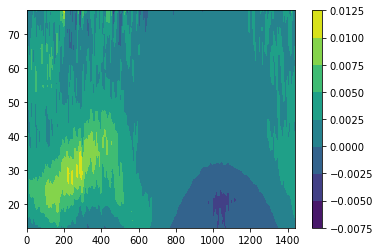

In [54]:
%matplotlib inline
py.contourf(range(1440),latn[1000:-100], fo_dUdz_sfc[1000:-100,:]/(f[1000:-100,:]));py.colorbar()

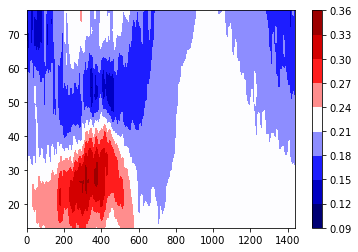

In [55]:
%matplotlib inline
py.contourf(range(1440),latn[1000:-100], np.sqrt(N_sq_sfc)[1000:-100,:],cmap=cm.seismic); py.colorbar()

In [56]:
Ri= fo_dUdz_sfc[1000:-100,:]/(f[1000:-100,:]*np.sqrt(N_sq_sfc)[1000:-100,:])

In [57]:
Rii= np.reshape(Ri,(641,12,30,4)).mean(axis=-1).mean(axis=-1)

In [59]:
Rii.shape
pos= np.array([38.57487012, 39.90803517, 42.71426456, 46.02972537, 47.36047713,
       47.23665445, 51.10316685,         np.nan, 53.92576279, 54.87475346,
       51.71721502, 45.49713626, 38.57487012])[:-1]

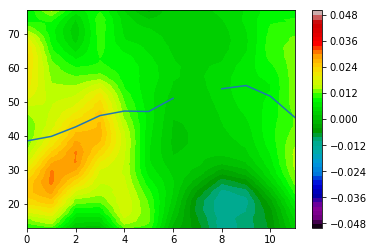

In [60]:
%matplotlib inline
v=np.arange(-0.05, 0.052,0.002)
py.contourf(range(12),latn[1000:-100], Rii ,v,cmap=cm.spectral); py.colorbar()
py.plot(pos)